In [1]:
import sys
import os
from dotenv import load_dotenv
load_dotenv()
sys.path.insert(0, os.getenv('SRC_PATH'))

import numpy as np
import pandas as pd
import seaborn as sns
import sqlite3
from src.volsurface import GridInterpVolSurface, KernelVolSurface
from src.utils.data_helper import clean_data, VolSurfPointwiseDataset

import torch
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from src.train import Trainer

import json

DB_PATH = os.getenv('DB_PATH')
CSV_PATH = os.getenv('CSV_PATH')
conn = sqlite3.connect(DB_PATH)
cursor = conn.cursor()

pd.set_option('future.no_silent_downcasting', True)

from src.utils.logger import setup_logger
logger = setup_logger('train')

/Users/zhanghq/miniconda3/envs/vae-volsurface/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-18 21:44:36,513	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-04-18 21:44:36,628	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
model_name = "vae_pw_ii"
train_model = True
load_model = False
save_model = False
data_dir = CSV_PATH + "/predicted_vol_surfaces.json"  # Path to the volatility surfaces dataset
batch_size = 32
epochs = 8

In [3]:
maturity_grid = np.array([1, 7, 30, 60, 90, 180, 360, 720])
delta_grid = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [4]:
SRC_PATH = os.getenv('SRC_PATH')
os.chdir(SRC_PATH)
trainer = Trainer(model_name)
trainer.create_model()

[2025-04-18 21:44:36] [INFO] src.train (60) : Using device: mps


In [5]:
with open(data_dir, "r") as f:
    data = json.load(f)

[2025-04-18 23:15:07] [INFO] src.train (136) : Model loaded from params/vae_pw_ii_dumb.pth


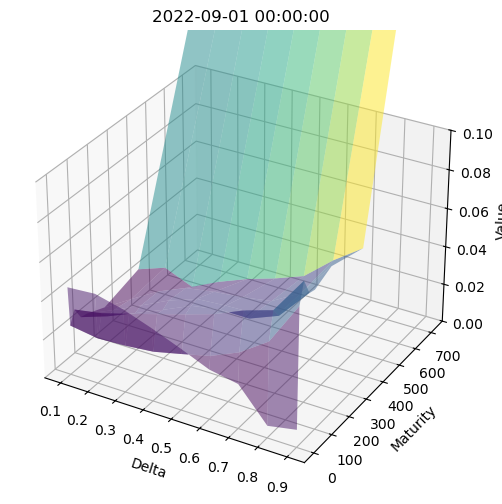

In [98]:
import random
date = random.choice(list(data.keys()))

mean, logvar = trainer.model.encoder(torch.tensor(data[date]).flatten().to(trainer.device))
mean
trainer.model.reparameterize(*trainer.model.encoder(torch.tensor(data[date]).flatten().to(trainer.device)))
from src.volsurface import VAEPWVolSurface
trainer.load_model("params/vae_pw_ii_dumb.pth")
vaevsurf = VAEPWVolSurface(trainer.model, latent=mean.detach().cpu().numpy())
vaevsurf.refresh()
pred = vaevsurf.predict_grid(delta_grid, maturity_grid)
true = np.array(data[date])
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

X, Y = np.meshgrid(delta_grid, maturity_grid, indexing='ij')

# # Plot true values
# ax.plot_surface(X, Y, true, color='red', alpha=0.2, label='True Values')

# # Plot predicted values
# ax.plot_surface(X, Y, pred, color='blue', alpha=0.2, label='Predicted Values')

ax.plot_surface(X, Y, np.abs(true - pred), cmap='viridis', alpha=0.5, label='Error Surface')

ax.set_title(date)
ax.set_xlabel('Delta')
ax.set_ylabel('Maturity')
ax.set_zlabel('Value')

ax.set_zlim(0, 0.1)

plt.show()
